In [3]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
from ipywidgets import Layout, Button, Box
from nested_dict import nested_dict
import ipywidgets as widgets

import json
import os, glob
import pandas as pd
import pandas.io.json as pdjson
import seaborn as sns

sns.set_style("whitegrid")

In [4]:
artifacts_dir = "/Users/kc/repos/sandmark-nightly/parallel/"
pausetimes_dir = "/Users/kc/repos/sandmark-nightly/pausetimes/parallel"
default_hostname = None

In [5]:
bench_files = []

artifacts_path = artifacts_dir.split("/parallel/")[0]

for root, dirs, files in os.walk(artifacts_dir):
    for file in files:
        if file.endswith("_1.orunchrt.summary.bench"):
            f = root.split("/parallel/")
            bench_files.append((os.path.join(root, file)))

In [6]:
def files_to_dict(files):
    benches = nested_dict(2, list)
    for x in files:
        l = x.split("/parallel/")[1]
        d = l.split("/")
        host         = d[0]
        timestamp    = d[1]
        commit       = d[2]
        variant      = d[3]
        variant_root = d[3].split('_')[0]
        variant_stem = d[3].split('_')[1]
        value        = variant_root + '+' + commit + '_' + variant_stem
        benches[host][timestamp].append(value)
    benches = dict(benches)
    for i in benches.items():
        benches[i[0]] = dict(sorted(i[1].items(), key=lambda t : t[0], reverse=True))
    return benches

benches = files_to_dict(bench_files)

In [7]:
def f(x): return x

def disp(benches):
    def select_host(host):
        timestampW.options = benches[host]
    
    def select_commit(timestamp):
        variantW.options = timestamp
    
    def do_nothing(variant):
        return None
    
    hostW = widgets.Dropdown(options=benches.keys(), description='Host', disabled=False)
    hostS = hostW.value
    hostD = widgets.interactive(select_host, host=hostW)

    timestampW = widgets.Dropdown(options=benches[hostS].keys(), description='Timestamp', disabled=False)
    timestampS = timestampW.value
    timestampD = widgets.interactive(select_commit, timestamp=timestampW)
    
    variantW = widgets.Dropdown(options=benches[hostS][timestampS], description='Variant', disabled=False)
    variantD = widgets.interactive(do_nothing, variant=variantW)

    items_layout = Layout( width='auto' )
    
    box_layout = Layout(display='flex',
                       flex_flow='row wrap',
                       align_items='flex-start',
                       width='100%')
    items = [hostD, timestampD, variantD]
    box = Box(children=items, layout=box_layout)
    display(box)
    
    return (hostD, timestampD, variantD)

def get_filename(h, t, v):
    host      = h.children[0].value

    timestamps = list(benches[host].keys())
    timestamp  = timestamps[t.children[0].index]

    entries      = list(benches[host][timestamp])
    variant      = entries[v.children[0].index]
    commit       = variant.split('_')[0].split('+')[-1]
    variant_stem = variant.split('_')[1]
    variant_value = '+'.join(variant.split('_')[0].split('+')[:-1]) + '_' + variant_stem

    filename = os.path.join(
        artifacts_dir,
        host,
        timestamp,
        commit,
        variant_value
    )
    return filename

In [8]:
if default_hostname is None:
    value = 2
else:
    value = 1


comparisons = interactive(f, x=widgets.IntText(value=value, 
                                               description='Comparisons', 
                                               disabled=False))
display(comparisons)

interactive(children=(IntText(value=2, description='Comparisons'), Output()), _dom_classes=('widget-interact',…

In [9]:
print(comparisons.result)

# if-cond for generating html
if default_hostname:
    timestamp = list(benches[default_hostname])[0]
    bench_files = [(timestamp, benches[default_hostname][timestamp])]
    bench1 = {
        default_hostname : {
            timestamp : [bench_files[0][1][0]]
        }
    }

1


In [10]:
# # if-cond for generating html
# if default_hostname is None:
matrix = [[0 for x in range(4)] for y in range(comparisons.result)]  
    
for i in range(comparisons.result):
    matrix[i][0], matrix[i][1], matrix[i][2] = disp(benches)

Box(children=(interactive(children=(Dropdown(description='Host', options=('navajo', 'turing'), value='navajo')…

In [11]:
for i in range(comparisons.result):
    matrix[i][3] = get_filename(matrix[i][0], matrix[i][1], matrix[i][2])

In [12]:
selected_files = []
for i in range (comparisons.result):
    selected_files.append(matrix[i][3])

In [13]:
data_frames = []

for file in selected_files:
    with open(file) as f:
        data = []
        for l in f:
            data.append(json.loads(l))
        df = pd.json_normalize(data)
        value     = file.split('/parallel/')[1]
        date      = value.split('/')[1].split('_')[0]
        commit_id = value.split('/')[2][:7]
        variant   = value.split('/')[3].split('_')[0]
        df["variant"] = variant + '_' + date + '_' + commit_id
        data_frames.append(df)

df = pd.concat (data_frames, sort=False)
df = df.sort_values(['name','time_secs']) 
# Uncomment the following to display all the lines in pandas output
# pd.set_option('display.max_rows', df.shape[0]+1)

In [18]:
import re

def renameLabel(n,topic=""):
    n = n.replace("name = ","")
    if (topic==""):
        return re.sub("_multicore\..*","",n)
    return re.sub("_multicore\..*","",n) + " (" + str(mdf.loc[mdf['name'] == n]['b'+topic].values[0]) + ")"

def getFastestSequential(df,topic):
    fastest_sequential = {}
    for g in df.groupby(['name']):
        (n,d) = g
        fastest_sequential[n] = min(list(d[topic]))
    return fastest_sequential

def normalize(sdf, mdf, topic):
    frames = []
    fastest_sequential = getFastestSequential(sdf, topic)
    for g in mdf.groupby('name'):        
        (n,d) = g
        n = n.replace('_multicore','')
        d['n'+topic] = 1 / d[topic].div(fastest_sequential[n],axis=0)
        d['b'+topic] = int(fastest_sequential[n])
        frames.append(d)
    return pd.concat(frames)


# Sequential runs
sdf = df.loc[~df['name'].str.contains('multicore',regex=False),:]
throughput_sdf = pd.DataFrame.copy(sdf)

# Multicore runs
mdf = df.loc[df['name'].str.contains('multicore',regex=False),:]
mdf['num_domains'] = mdf['name'].str.split('.',expand=True)[1].str.split('_',expand=True)[0]
mdf['num_domains'] = pd.to_numeric(mdf['num_domains'])
mdf['name'] = mdf['name'].replace('\..*?_','.',regex=True)

mdf = normalize(sdf,mdf,"time_secs")
throughput_mdf = pd.DataFrame.copy(mdf)
# mdf.sort_values(['name','variant','num_domains'])

<ipython-input-18-1815ad42086c>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdf['num_domains'] = mdf['name'].str.split('.',expand=True)[1].str.split('_',expand=True)[0]
<ipython-input-18-1815ad42086c>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdf['num_domains'] = pd.to_numeric(mdf['num_domains'])
<ipython-input-18-1815ad42086c>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [15]:
pd.set_option('display.max_rows', None)
df

,name,command,time_secs,user_time_secs,sys_time_secs,maxrss_kB,codesize,ocaml_url,ocaml.version,ocaml.c_compiler,...,gc.minor_words,gc.promoted_words,gc.major_words,gc.minor_collections,gc.major_collections,gc.forced_major_collections,gc.heap_words,gc.top_heap_words,gc.mean_space_overhead,variant
13,LU_decomposition.4096.orunchrt,taskset --cpu-list 4 chrt -r 1 ./LU_decomposit...,489.863917,489.561297,0.300000,529632,74362.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+domains+effects,gcc,...,137573192009,211,67109397,524803,4,0,67154186,67154186,1537.896940,4.12.0+domains+effects_20210920_d9d5c2a
31,LU_decomposition_multicore.120_4096.orunchrt,"taskset --cpu-list 4-63,68-127 chrt -r 1 ./LU_...",14.307711,1561.420091,58.801727,662008,113380.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+domains+effects,gcc,...,137629478841,29544398,96683568,808352,713,0,53496893,52447394,9.226623,4.12.0+domains+effects_20210920_d9d5c2a
89,LU_decomposition_multicore.16_4096.orunchrt,taskset --cpu-list 4-19 chrt -r 1 ./LU_decompo...,17.029575,240.456254,8.181042,432664,113380.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+domains+effects,gcc,...,137554211844,9069350,76182304,657155,5975,0,50843085,50679785,1.735468,4.12.0+domains+effects_20210920_d9d5c2a
87,LU_decomposition_multicore.1_4096.orunchrt,taskset --cpu-list 4 chrt -r 1 ./LU_decomposit...,208.020735,207.807910,0.211999,398604,113380.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+domains+effects,gcc,...,137539652555,20236,67129422,524773,101,0,50385159,50385159,0.313203,4.12.0+domains+effects_20210920_d9d5c2a
18,LU_decomposition_multicore.32_4096.orunchrt,taskset --cpu-list 4-35 chrt -r 1 ./LU_decompo...,10.408366,294.639212,13.089858,468036,113380.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+domains+effects,gcc,...,137568268765,14344699,81461677,641708,2496,0,51326349,50945993,2.953610,4.12.0+domains+effects_20210920_d9d5c2a
48,LU_decomposition_multicore.64_4096.orunchrt,"taskset --cpu-list 4-63,68-71 chrt -r 1 ./LU_d...",8.222741,457.938673,31.221890,537792,113380.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+domains+effects,gcc,...,137594523921,22068386,89193444,720711,1230,0,35280916,51543945,5.469491,4.12.0+domains+effects_20210920_d9d5c2a
27,LU_decomposition_multicore.8_4096.orunchrt,taskset --cpu-list 4-11 chrt -r 1 ./LU_decompo...,30.777067,225.484069,4.262961,350976,113380.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+domains+effects,gcc,...,137546950754,5256352,72367302,645352,11569,0,33736694,50538489,1.063879,4.12.0+domains+effects_20210920_d9d5c2a
79,LU_decomposition_multicore.96_4096.orunchrt,"taskset --cpu-list 4-63,68-103 chrt -r 1 ./LU_...",10.281551,861.599674,63.201973,583864,113380.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+domains+effects,gcc,...,137612721470,29804021,96937143,986873,1059,0,36146068,52101199,7.784211,4.12.0+domains+effects_20210920_d9d5c2a
68,binarytrees5.24.orunchrt,taskset --cpu-list 4 chrt -r 1 ./binarytrees5....,265.546568,264.529405,1.015990,1485448,284565.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+domains+effects,gcc,...,8942505379,3740184253,3740184571,34232,120,0,160801022,189403390,37.783488,4.12.0+domains+effects_20210920_d9d5c2a
86,binarytrees5_multicore.120_24.orunchrt,"taskset --cpu-list 4-63,68-127 chrt -r 1 ./bin...",41.018221,657.325726,176.412189,17202212,111996.0,https://github.com/ocaml-multicore/ocaml-multi...,4.12.0+domains+effects,gcc,...,8942478503,3303151177,3303181475,149364,18,0,856248548,2964617238,1.007400,4.12.0+domains+effects_20210920_d9d5c2a


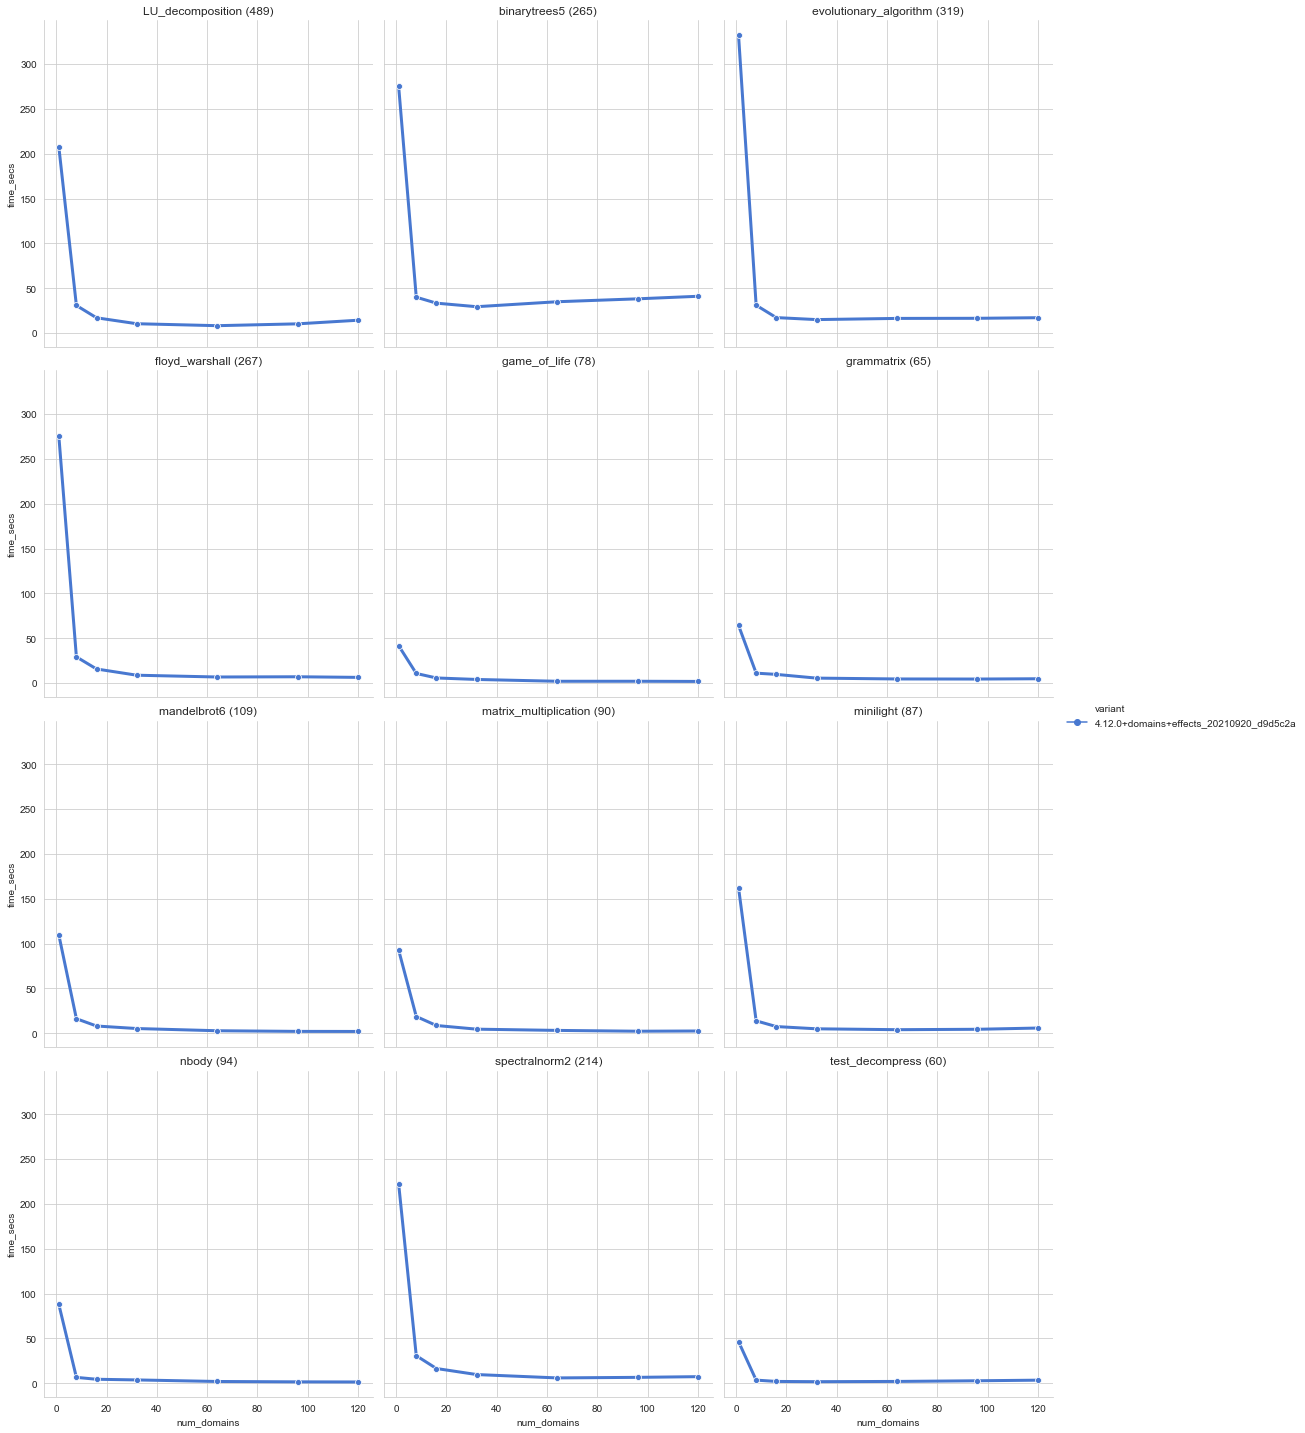

In [19]:
mdf = mdf.sort_values(['name'])
g = sns.relplot(x='num_domains', y = 'time_secs', hue='variant', col='name',
            data=mdf, kind='line', style='variant', markers=True, col_wrap = 3, 
            lw=3, palette="muted")
for ax in g.axes:
    ax.set_title(renameLabel(ax.title.get_text(),"time_secs"))
g

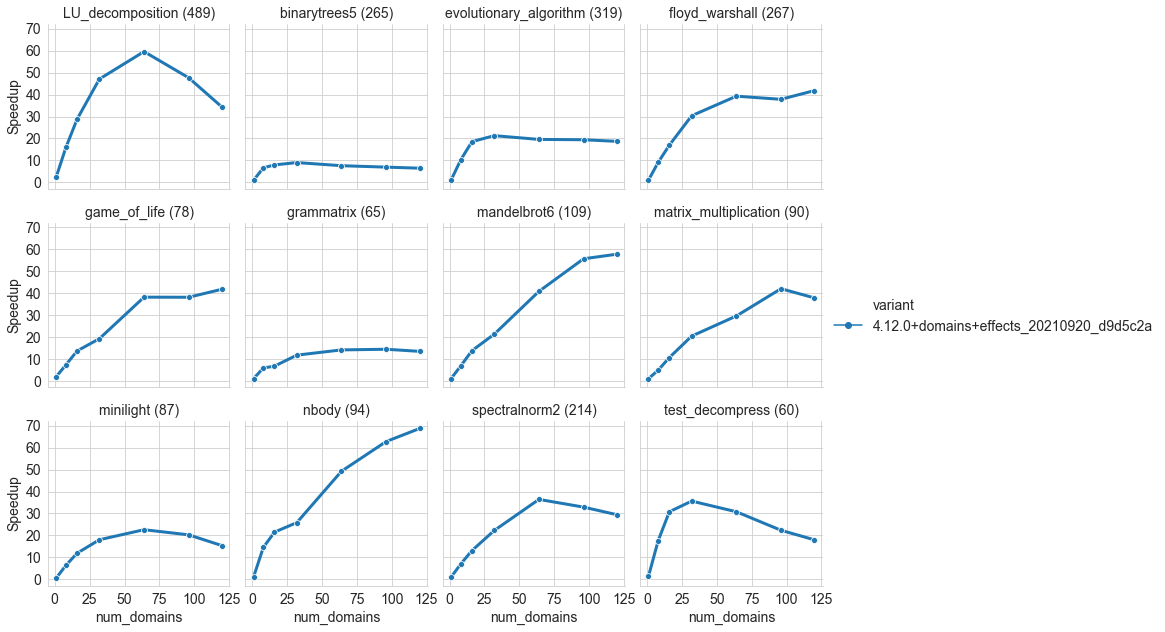

In [30]:
mdf = mdf.sort_values(['name'])
with sns.plotting_context(rc={"font.size":14,"axes.titlesize":14,"axes.labelsize":14,
                              "legend.fontsize":14}):
    g = sns.relplot(x='num_domains', y = 'ntime_secs', hue='variant', col='name',
                data=mdf, kind='line', style='variant', markers=True, col_wrap = 4, 
                lw=3, height=3)
    for ax in g.axes:
        ax.set_title(renameLabel(ax.title.get_text(),"time_secs"))
        ax.set_ylabel("Speedup")
    g

# Instrumented Pausetimes

In [31]:
def files_to_dict_pausetimes(files):
    benches = nested_dict(2, list)
    for x in files:
        l = x.split("/parallel/")[1]
        d = l.split("/")
        host         = d[0]
        timestamp    = d[1]
        commit       = d[2]
        variant      = d[3]
        variant_root = d[3].split('_')[0]
        variant_stem = d[3].split('_')[1] + '_' + d[3].split('_')[2]
        value        = variant_root + '+' + commit + '_' + variant_stem
        benches[host][timestamp].append(value)
    benches = dict(benches)
    for i in benches.items():
        benches[i[0]] = dict(sorted(i[1].items(), key=lambda t : t[0], reverse=True))
    return benches

In [32]:
pausetimes_files = []

for root, dirs, files in os.walk(pausetimes_dir):
    for file in files:
        if file.endswith("_1.pausetimes_multicore.summary.bench"):
            f = root.split("/parallel/")
            pausetimes_files.append((os.path.join(root, file)))

pausetimes = files_to_dict_pausetimes(pausetimes_files)

def f(x):
    return x

if default_hostname is None:
    value = 2
else:
    value = 1

pausetimes_comparisons = interactive(f, x=widgets.IntText(value=value, description='Comparisons', disabled=False))

display(pausetimes_comparisons)

interactive(children=(IntText(value=2, description='Comparisons'), Output()), _dom_classes=('widget-interact',…

In [34]:
def get_filename_pausetimes(h, t, v):
    # if-cond for generating html
    if default_hostname:
        host      = h.children[0].value

        timestamps = list(pausetimes[host].keys())
        timestamp  = timestamps[t.children[0].index]
        variant = v.children[0].value
        commit = variant.split('_')[0].split('+')[-1]
        variant_stem = variant.split('_')[1] + '_' + variant.split('_')[2]
        variant_value = '+'.join(variant.split('_')[0].split('+')[:-1]) + '_' + variant_stem
        
        filename = os.path.join(
            pausetimes_dir,
            host,
            timestamp,
            commit,
            variant_value
        )
        return(filename)
    
    host      = h.children[0].value

    timestamps = list(pausetimes[host].keys())
    timestamp  = timestamps[t.children[0].index]

    entries      = list(pausetimes[host][timestamp])
    variant      = entries[v.children[0].index]
    commit       = variant.split('_')[0].split('+')[-1]
    variant_stem = variant.split('_')[1] + '_' + variant.split('_')[2]
    
    variant_value = '+'.join(variant.split('_')[0].split('+')[:-1]) + '_' + variant_stem

    filename = os.path.join(
        pausetimes_dir,
        host,
        timestamp,
        commit,
        variant_value
    )
    return filename

In [35]:
print(pausetimes_comparisons.result)
# if-cond for generating html
if default_hostname:
    timestamp = list(pausetimes[default_hostname])[0]
    pausetimes_files = [(timestamp, pausetimes[default_hostname][timestamp])]
    pausetimes1 = {
        default_hostname : {
            timestamp : [pausetimes_files[0][1][0]]
        }
    }

1


In [36]:
pausetimes_matrix = [[0 for x in range(4)] for y in range(pausetimes_comparisons.result)]
# if-cond for generating html
if default_hostname is None:
    for i in range(pausetimes_comparisons.result):
        pausetimes_matrix[i][0], pausetimes_matrix[i][1], pausetimes_matrix[i][2] = disp(pausetimes)
else:
    pausetimes_matrix[0][0], pausetimes_matrix[0][1], pausetimes_matrix[0][2] = disp(pausetimes1)

Box(children=(interactive(children=(Dropdown(description='Host', options=('navajo', 'turing'), value='navajo')…

In [37]:
for i in range(pausetimes_comparisons.result):
    pausetimes_matrix[i][3] = get_filename_pausetimes(
        pausetimes_matrix[i][0], pausetimes_matrix[i][1], pausetimes_matrix[i][2])

In [38]:
data_frames = []

def fmt_variant(file):
    variant   = file.split('/')[-1].split('_1')[0]
    commit_id = file.split('/')[-2][:7]
    date      = file.split('/')[-3].split('_')[0]
    return str(variant + "+" + date + "+" + commit_id)

for i in range(pausetimes_comparisons.result):
    file = pausetimes_matrix[i][3]
    with open(file) as f:
        data = []
        for l in f:
            data.append(json.loads(l))
        ldf = pd.json_normalize(data)
    variant = fmt_variant(file)
    ldf['variant'] = variant
    data_frames.append(ldf)

df2 = pd.concat(data_frames, sort=False)

mdf2 = df2.loc[df2['name'].str.contains('.*multicore.*',regex=True),:]
mdf2['num_domains'] = mdf2['name'].str.split('.',expand=True)[1].str.split('_',expand=True)[0]
mdf2['num_domains'] = pd.to_numeric(mdf2['num_domains'])
mdf2['name'] = mdf2['name'].replace('\..*?_','.',regex=True)

latency_df = pd.DataFrame.copy(mdf2)
mdf2 = mdf2.drop_duplicates(subset=["name","variant", "max_latency", "num_domains"])
mdf2.sort_values(["name"])

<ipython-input-38-731037a2c267>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdf2['num_domains'] = mdf2['name'].str.split('.',expand=True)[1].str.split('_',expand=True)[0]
<ipython-input-38-731037a2c267>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdf2['num_domains'] = pd.to_numeric(mdf2['num_domains'])
<ipython-input-38-731037a2c267>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

,name,mean_latency,max_latency,distr_latency,variant,num_domains
70,LU_decomposition_multicore.4096,163945,35834396,"[8102, 9988, 13270, 96242, 124946, 157911, 176...",4.12.0+domains+effects+instrumented+20210920+d...,16
26,LU_decomposition_multicore.4096,250270,43657075,"[12362, 16134, 17670, 93517, 155955, 196044, 2...",4.12.0+domains+effects+instrumented+20210920+d...,32
89,LU_decomposition_multicore.4096,43287,6227808,"[7613, 7752, 8031, 8102, 75428, 75987, 76266, ...",4.12.0+domains+effects+instrumented+20210920+d...,1
71,LU_decomposition_multicore.4096,121616,95855153,"[7962, 8172, 9499, 82412, 97289, 129765, 14003...",4.12.0+domains+effects+instrumented+20210920+d...,8
7,LU_decomposition_multicore.4096,344364,60937664,"[13899, 16762, 18159, 19974, 204774, 244164, 2...",4.12.0+domains+effects+instrumented+20210920+d...,64
37,LU_decomposition_multicore.4096,432628,89666797,"[12502, 14667, 16552, 19066, 285231, 336914, 3...",4.12.0+domains+effects+instrumented+20210920+d...,120
9,LU_decomposition_multicore.4096,393732,64978109,"[13689, 16064, 17670, 19555, 252545, 318336, 3...",4.12.0+domains+effects+instrumented+20210920+d...,96
16,binarytrees5_multicore.24,34508824,8291345939,"[8521, 11104, 13969, 16553, 267841, 390621, 75...",4.12.0+domains+effects+instrumented+20210920+d...,96
60,binarytrees5_multicore.24,3176676,4006907351,"[7752, 8032, 8241, 9428, 128019, 169853, 81366...",4.12.0+domains+effects+instrumented+20210920+d...,8
73,binarytrees5_multicore.24,19044890,6366666508,"[8590, 11314, 14807, 17600, 205682, 300737, 68...",4.12.0+domains+effects+instrumented+20210920+d...,64


## Max latency

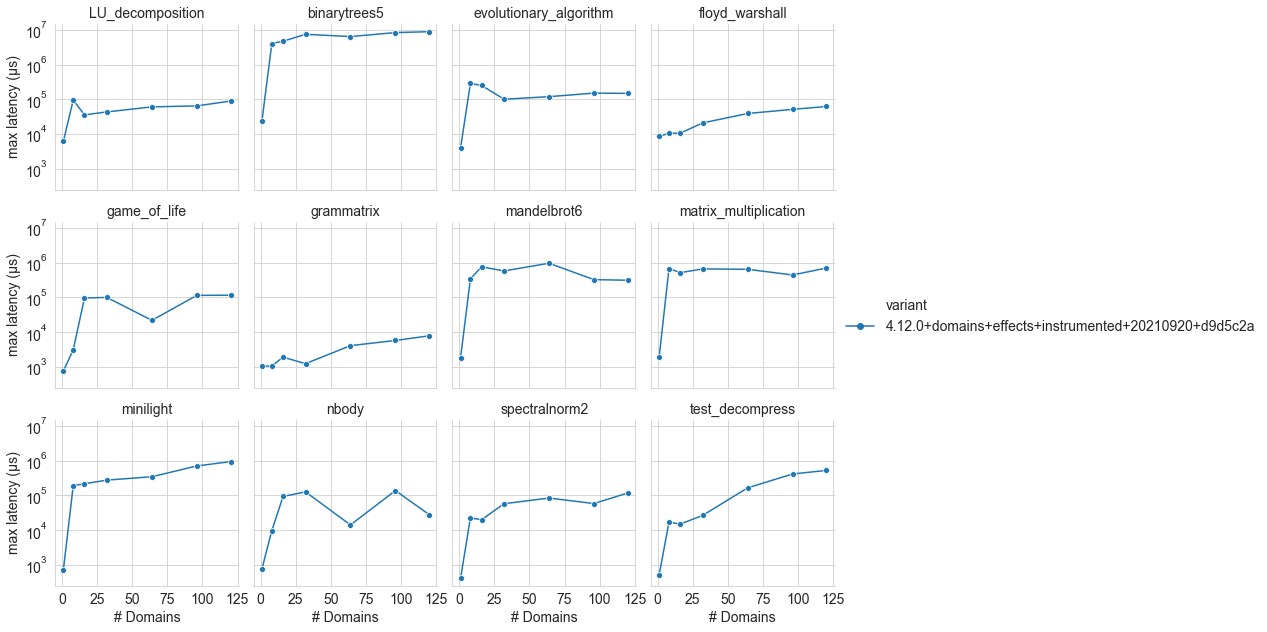

In [52]:
def renameForLatency(n):
    n = n.replace("name = ","")
    return re.sub("_multicore\..*","",n)


def plotLatencyAt(df,at):
    fdf = df.filter(["name","variant",at + "_latency","num_domains"])
    fdf.sort_values(by="name",inplace=True)
    fdf[at + "_latency"] = fdf[at + "_latency"] / 1000.0
    with sns.plotting_context(rc={"font.size":14,"axes.titlesize":14,"axes.labelsize":14,
                                  "legend.fontsize":14}):
        g = sns.relplot(x='num_domains', y = at + '_latency', hue='variant', col='name',
                        data=fdf, kind='line', style='variant', markers=True, col_wrap = 4, 
                        height = 3)
        for ax in g.axes:
            ax.set_title(renameForLatency(ax.title.get_text()))
            ax.set_ylabel(at + " latency (μs)")
            ax.set_xlabel("# Domains")
            ax.set_yscale('log')
            
        
plotLatencyAt(mdf2,"max")

## 99.9th percentile latency

84


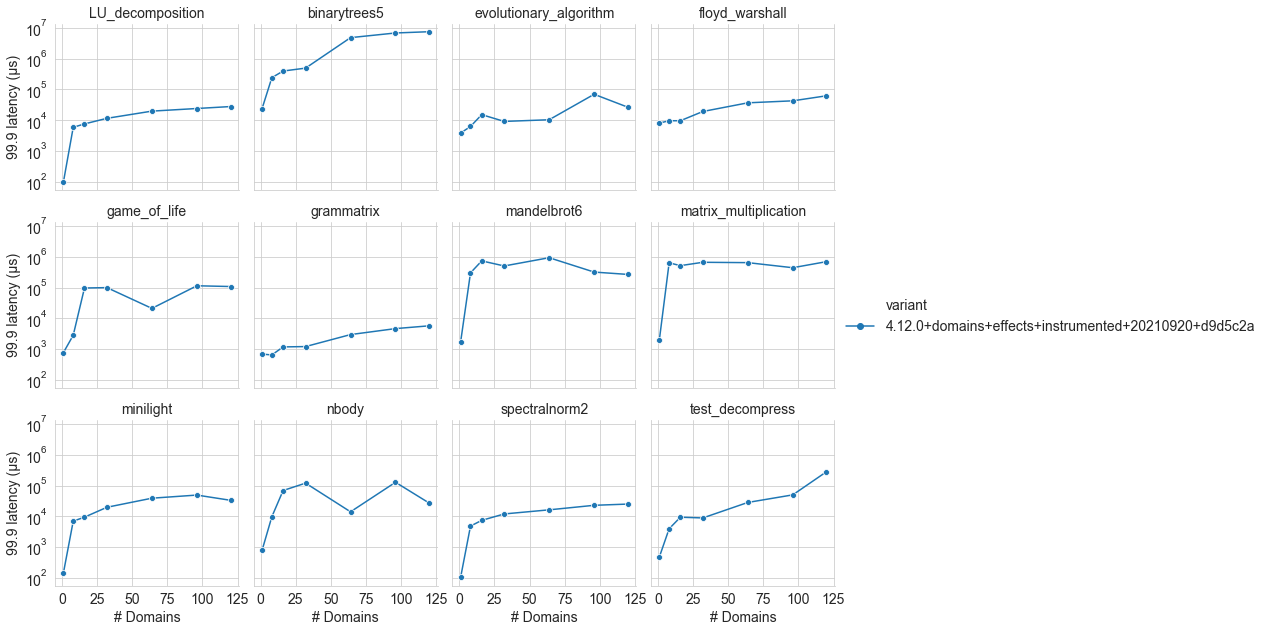

In [53]:
def getLatencyAt(df,percentile,idx):
    groups = df.groupby('variant')
    ndfs = []
    for group in groups:
        (v,df) = group
        count = 0
        for i, row in df.iterrows():
            count += 1
            df.at[i,percentile+"_latency"] = list(df.at[i,"distr_latency"])[idx]
        print(count)
        ndfs.append(df)
    return pd.concat(ndfs)

mdf2 = getLatencyAt(mdf2,"99.9",-1)
plotLatencyAt(mdf2,"99.9")

## 99th percentile latency

84


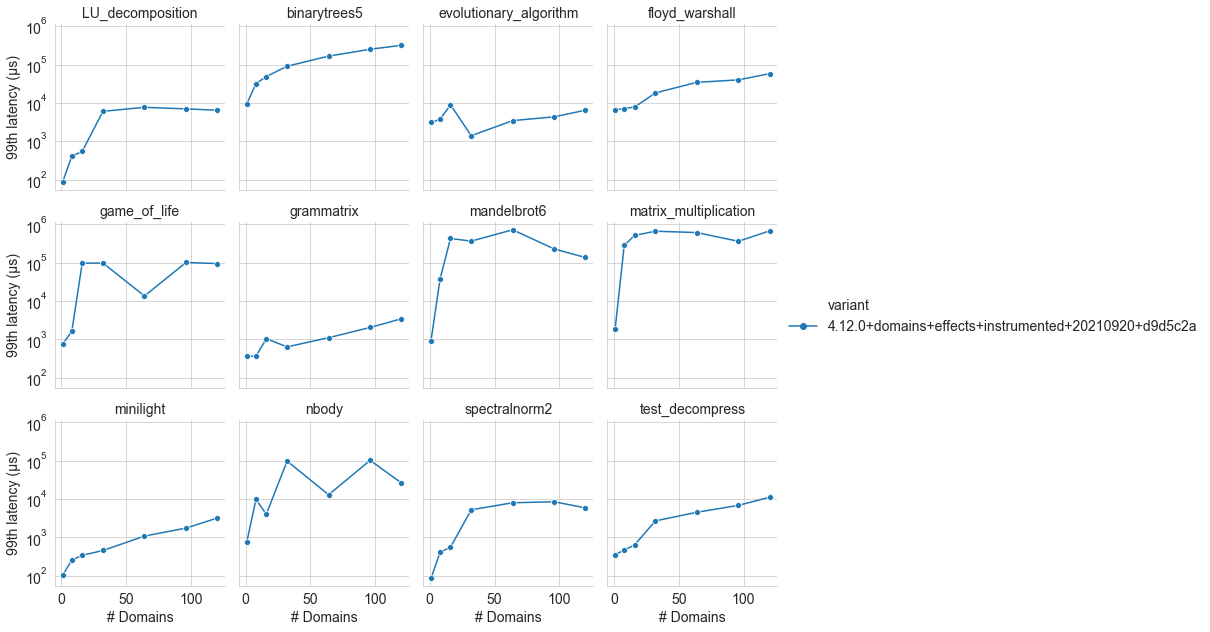

In [57]:
mdf2 = getLatencyAt(mdf2,"99th",-2)
plotLatencyAt(mdf2,"99th")

## Mean latency

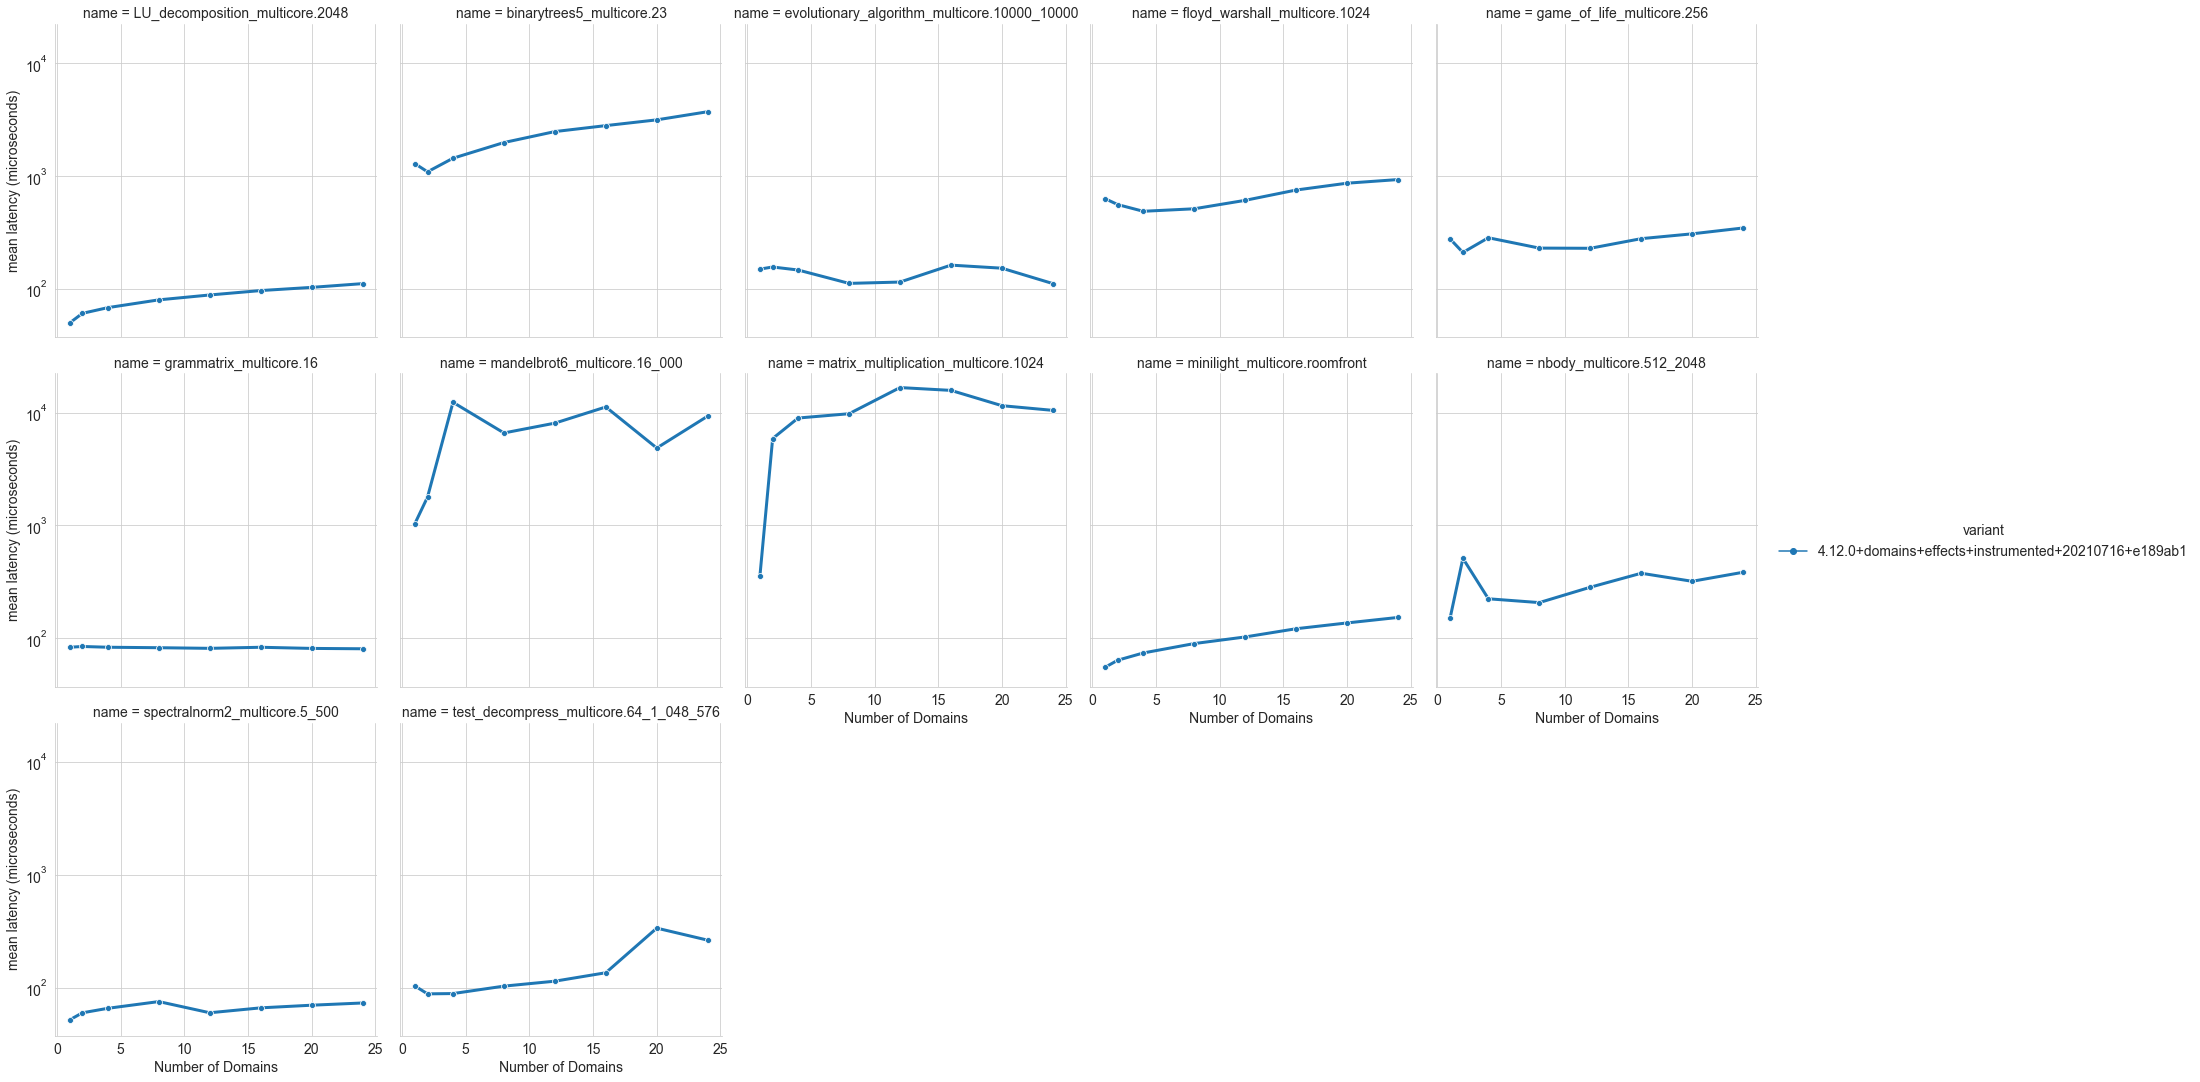

In [149]:
plotLatencyAt(mdf2,"mean")